Using TensorFlow backend.


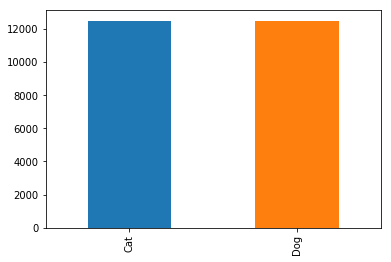

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras import models,layers,optimizers
from keras.layers import BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,load_img


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


import os
#print(os.listdir("../input/train/train"))

# Any results you write to the current directory are saved as output.
filenames = os.listdir("../input/train/train")
categories = []
for file in filenames:
    if file.split(".")[0]=='dog':
        categories.append('Dog')
    else:
        categories.append('Cat')

#print(categories[:10])
data = pd.DataFrame(
        {'filename':filenames,
        'category':categories})
#data.head()
data['category'].value_counts().plot.bar()



In [2]:
model =models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (128,128,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(Dropout(0.25))                            #Adding regularization
model.add(layers.Flatten())
model.add(BatchNormalization())
model.add(layers.Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxP

In [3]:
train_X, val_X = train_test_split(data, test_size=0.20, random_state=42)
train_X = train_X.reset_index(drop=True)
val_X = val_X.reset_index(drop=True)
total_train = train_X.shape[0]
print(total_train)
total_val = val_X.shape[0]
batch_size=40
print(train_X.shape)



20000
(20000, 2)


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
#test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_X,
    "../input/train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (128,128),
    class_mode = 'binary',
    batch_size = batch_size)




Found 20000 images belonging to 2 classes.


In [5]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_X,
    "../input/train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (128,128),
    class_mode = 'binary',
    batch_size = batch_size)



Found 5000 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


history = model.fit_generator(
train_generator,
steps_per_epoch=total_train//batch_size,
epochs=50,
validation_data=val_generator,
validation_steps=total_val//batch_size,
callbacks=callbacks)


Instructions for updating:
Use tf.cast instead.


In [ ]:
model.save('catndogs_wo_pretrain_nw.h5')

In [ ]:
acc=history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_files = os.listdir("../input/test1/test1")
test_X = pd.DataFrame({
    'filename': test_files
})

samples = test_X.shape[0]
print(samples)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_X, 
    "../input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=40,
    shuffle=False
)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))

In [ ]:
threshold = 0.5
test_X['probability'] = predict
test_X['category'] = np.where(test_X['probability'] > threshold, '1','0')

In [ ]:
from keras.preprocessing.image import load_img
sample_test = test_X.head(15)
sample_test.head()
plt.figure(figsize=(15, 30))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=(128,128))
    plt.subplot(5, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) +')')
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_X.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)